# Project Sunset
2020년 과학 탐구 보고서 발표 대회에 사용될 코드입니다.

-----------------------------------------------------------------------------------------

FGSM 공격용 이미지와 정상적인 이미지를 분류할 ResNet 코드입니다.

### (1) 필요 라이브러리 및 프레임워크 임포트 & 사용 디바이스 선택(CPU or GPU)

In [117]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import random
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from IPython.display import clear_output

In [118]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

### (2) 하이퍼 파라미터 선언

In [131]:
EPOCHS     = 300
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 10

MODEL_PATH = './model/PreTrained ResNet/preTrainedResNet.pt'

### (3) 데이터셋 로드

In [120]:
train_cifar_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_cifar_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


### (4) FGSM 공격용 이미지 분류할 DefendResNet

In [121]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class DefendResNet(nn.Module):
    def __init__(self, channels=3, num_classes=2):
        super(DefendResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.size())
        out = self.conv1(x)
        #print(out.size())
        out = self.bn1(out)
        #print(out.size())
        out = F.relu(out)
        #print(out.size())
        out = self.layer1(out)
        #print(out.size())
        out = self.layer2(out)
        #print(out.size())
        out = self.layer3(out)
        #print(out.size())
        out = F.avg_pool2d(out, 8)
        #print(out.size())
        out = out.view(out.size(0), -1)
        #print(out.size())
        out = self.linear(out)
        #print(out.size())
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

### (5) 해킹할 ResNet 로드

In [122]:
preTrainedResNet = torch.load(MODEL_PATH)

### (6) FGSM 어택 함수 선언

In [123]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [124]:
def getPertubedImage(img_tensor, original_image, epsilon, model):
    img_tensor = img_tensor#.unsqueeze(0)
    target = original_image
    img_tensor.requires_grad_(True)
    output = model(img_tensor)
    loss = F.nll_loss(output, target) 
    
    model.zero_grad()
    
    loss.requires_grad_(True)
    loss.backward()
    
    gradient = img_tensor.grad.data
    perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)
    return perturbed_data#.squeeze(0)

In [125]:
class CustomDataset(Dataset): 
  def __init__(self, cifar, _model):
    self.x_data = []
    self.y_data = None
    self.mix = {}
    self.model = _model
    
    for batch_idx, (data, target) in enumerate(cifar):
        self.x_data.append(data)
        self.mix[data]=target

  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    if random.randint(0, 1) == 0 :
        #왜곡 X
        #print("왜곡 X")
        x = self.x_data[idx]
        y = torch.tensor(0)
    else :
        #왜곡 O
        #print("왜곡 O")
        x = self.x_data[idx]
        x = getPertubedImage(torch.tensor(x), torch.tensor(self.mix[x]), random.uniform(0.01, 0.8), self.model)
        y = torch.tensor(1)
    
    #print(x.size())
    #print(y.size())
    return x.squeeze(0), y

In [126]:
train_loader = DataLoader(CustomDataset(train_cifar_loader, preTrainedResNet), batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(CustomDataset(test_cifar_loader, preTrainedResNet), batch_size=TEST_BATCH_SIZE, shuffle=True)

In [134]:
model = DefendResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        print("{0}번째 학습 - {1}번 배치".format(epoch, batch_idx))
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        #print("Train")
        output = model(data)
        #target=torch.argmax(target, dim=0)
        #print("--------------------------------------------------------------------------")
        #print("결과 : " + str(output))
        #print("결과 사이즈 : " + str(output.size()))
        #print("타겟 : " + str(target))
        #print("타겟 사이즈 : " + str(target.size()))
        #print("--------------------------------------------------------------------------")
        
        #loss = F.cross_entropy(output, torch.max(target,1)[1])
        loss = F.cross_entropy(output, target)
        
        loss.backward()
        optimizer.step()
        
        if batch_idx >= TRAIN_BATCH_SIZE - 1:
            break
        
        
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    #print("test start")
    '''
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            #target=torch.argmax(target, dim=0)
            #print(output)
            #print(target)
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
'''
    for batch_idx, (data, target) in enumerate(test_loader):
        
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)

        test_loss += F.cross_entropy(output, target, reduction='sum').item()

        # 가장 높은 값을 가진 인덱스가 바로 예측값
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        print('--------------------------------------------------------------------------------------------------------')
        pic = np.transpose(data.detach().numpy()[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()
        print("예측한 답안 : " + str(pred.data))
        print("실제 답안 : " + str(target.data))
        
        if batch_idx >= TEST_BATCH_SIZE - 1:
            break
        
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

C:\Users\LHZ\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1번째 학습 - 0번 배치
1번째 학습 - 1번 배치
1번째 학습 - 2번 배치
1번째 학습 - 3번 배치
1번째 학습 - 4번 배치
1번째 학습 - 5번 배치
1번째 학습 - 6번 배치
1번째 학습 - 7번 배치
1번째 학습 - 8번 배치
1번째 학습 - 9번 배치
--------------------------------------------------------------------------------------------------------


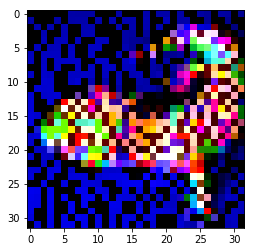

예측한 답안 : tensor([[1]])
실제 답안 : tensor([1])

[1] Test Loss: 0.0000, Accuracy: 0.01%
--------------------------------------------------------------------------------------------------------
2번째 학습 - 0번 배치
2번째 학습 - 1번 배치
2번째 학습 - 2번 배치
2번째 학습 - 3번 배치
2번째 학습 - 4번 배치
2번째 학습 - 5번 배치
2번째 학습 - 6번 배치
2번째 학습 - 7번 배치
2번째 학습 - 8번 배치
2번째 학습 - 9번 배치
--------------------------------------------------------------------------------------------------------


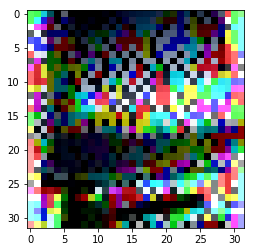

예측한 답안 : tensor([[1]])
실제 답안 : tensor([1])

[2] Test Loss: 0.0000, Accuracy: 0.01%
--------------------------------------------------------------------------------------------------------
3번째 학습 - 0번 배치
3번째 학습 - 1번 배치
3번째 학습 - 2번 배치
3번째 학습 - 3번 배치
3번째 학습 - 4번 배치
3번째 학습 - 5번 배치
3번째 학습 - 6번 배치
3번째 학습 - 7번 배치
3번째 학습 - 8번 배치
3번째 학습 - 9번 배치
--------------------------------------------------------------------------------------------------------


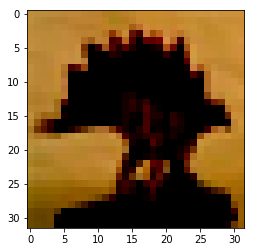

예측한 답안 : tensor([[1]])
실제 답안 : tensor([0])

[3] Test Loss: 0.0001, Accuracy: 0.00%
--------------------------------------------------------------------------------------------------------
4번째 학습 - 0번 배치
4번째 학습 - 1번 배치
4번째 학습 - 2번 배치
4번째 학습 - 3번 배치
4번째 학습 - 4번 배치
4번째 학습 - 5번 배치
4번째 학습 - 6번 배치
4번째 학습 - 7번 배치
4번째 학습 - 8번 배치
4번째 학습 - 9번 배치
--------------------------------------------------------------------------------------------------------


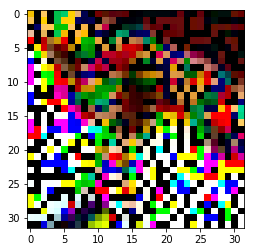

예측한 답안 : tensor([[0]])
실제 답안 : tensor([1])

[4] Test Loss: 0.0018, Accuracy: 0.00%
--------------------------------------------------------------------------------------------------------
5번째 학습 - 0번 배치
5번째 학습 - 1번 배치
5번째 학습 - 2번 배치
5번째 학습 - 3번 배치
5번째 학습 - 4번 배치
5번째 학습 - 5번 배치
5번째 학습 - 6번 배치
5번째 학습 - 7번 배치
5번째 학습 - 8번 배치
5번째 학습 - 9번 배치


--------------------------------------------------------------------------------------------------------


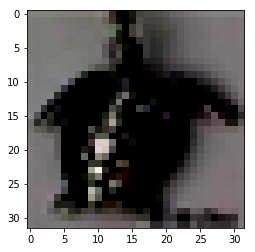

예측한 답안 : tensor([[0]])
실제 답안 : tensor([0])

[5] Test Loss: 0.0000, Accuracy: 0.01%
--------------------------------------------------------------------------------------------------------
6번째 학습 - 0번 배치
6번째 학습 - 1번 배치
6번째 학습 - 2번 배치
6번째 학습 - 3번 배치
6번째 학습 - 4번 배치
6번째 학습 - 5번 배치
6번째 학습 - 6번 배치
6번째 학습 - 7번 배치
6번째 학습 - 8번 배치


6번째 학습 - 9번 배치
--------------------------------------------------------------------------------------------------------


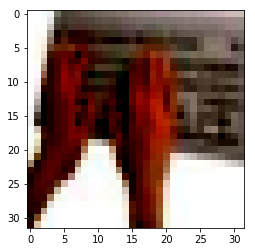

예측한 답안 : tensor([[1]])
실제 답안 : tensor([0])

[6] Test Loss: 0.0002, Accuracy: 0.00%
--------------------------------------------------------------------------------------------------------
7번째 학습 - 0번 배치
7번째 학습 - 1번 배치
7번째 학습 - 2번 배치
7번째 학습 - 3번 배치
7번째 학습 - 4번 배치
7번째 학습 - 5번 배치
7번째 학습 - 6번 배치
7번째 학습 - 7번 배치
7번째 학습 - 8번 배치
7번째 학습 - 9번 배치
--------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [135]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('\n[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
    print('--------------------------------------------------------------------------------------------------------')

In [ ]:
torch.save(model, '.\\Defend ResNet\\DefendResNet.pt')